# Classifying real vs. AI-generated images

In this notebook we aim to classify real and AI-generated synethetic images, provided by the [CIFAKE](https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images) data set [1]. CIFAKE contains 60,000 real images from the CIFAR-10 data set [2], and 60,000 fake images generated using Stable Diffusion [1]. The data set is divided into 100,000 training images and 20,000 testing images [1].

We will be using [fastai](https://www.fast.ai/) built on top of [PyTorch](https://pytorch.org/) to build a model for the classification task.

In [1]:
from fastai.vision.all import *

# Ensure GPU acceleration is available
torch.cuda.is_available()

True

In [2]:
# The following is a temporary patch to fix a bug with VS Code displaying
# progress bars for Jupyter notebooks
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

## Step 1: Create a training data pipeline

We create a `DataBlock` to load images from the dataset into our model and split these into separate training and validation sets:

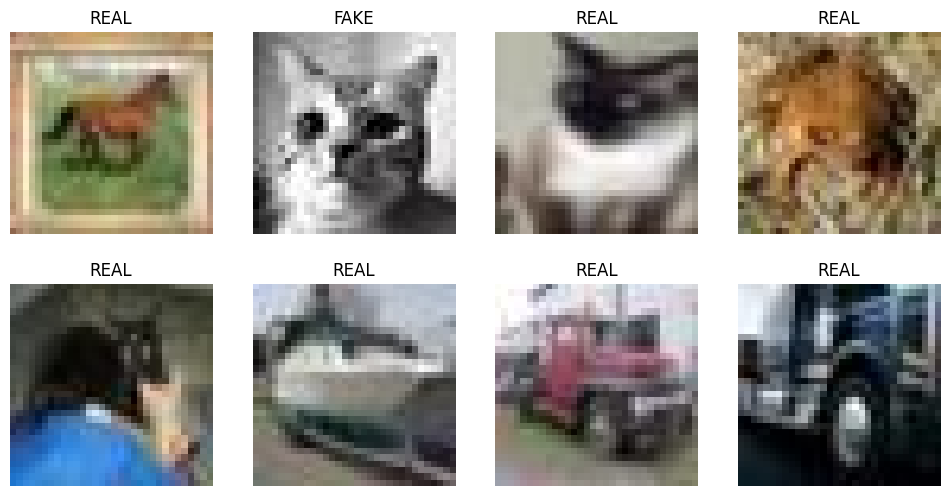

In [4]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label
).dataloaders(Path('..', 'data', 'cifake', 'train'))

dls.show_batch(max_n=8)

## Step 1b: Logistic regression

Run logistic regression on the principal components for a baseline accuracy.

In [68]:
from cv2 import imread

def load_images(filepath):
    return [imread(str(img_fp)) for img_fp in get_image_files(filepath)]

In [71]:
X_train = load_images(Path('..', 'data', 'cifake', 'train'))
y_train = np.array([0] * 50000 + [1] * 50000)

In [81]:
X_test = load_images(Path('..', 'data', 'cifake', 'test'))
y_test = np.array([0] * 10000 + [1] * 10000)

In [77]:
def flatten_images(images):
    return np.array([img.flatten() for img in images])

X_train_flat = flatten_images(X_train)
X_test_flat  = flatten_images(X_test)

In [83]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_train_flat)

X_train_pca = pca.transform(X_train_flat)
X_test_pca  = pca.transform(X_test_flat)

In [85]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X_train_pca, y_train)
print(f'Test accuracy: {clf.score(X_test_pca, y_test) * 100:.2f}%')

Test accuracy: 59.46%


## Step 2: Train the model

TODO: explain which model was chosen and why

In [53]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
# Or load a saved model to continue training
learn.load('resnet34-cifake-3epoch')
# learn.fine_tune(3)

c:\Users\deren\Git\elec4630\a3\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\deren\Git\elec4630\a3\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [48]:
learn.save(file='vit_b_16-cifake-3epoch')

Path('models/resnet34-cifake-3epoch.pth')

## Step 3: Test the model

In [49]:
test_path = Path('..', 'data', 'cifake', 'test')
test_dl = learn.dls.test_dl(get_image_files(test_path), with_labels=True)
_, preds, labels = learn.get_preds(dl=test_dl, with_decoded=True)

preds, labels = preds.numpy(), labels.numpy()

In [50]:
correct = sum(preds == labels)
total = len(labels)
acc = 100 * sum(preds == labels) / len(labels)

print(f'Test accuracy: {acc:.2f}% ({correct}/{total})')

Test accuracy: 96.48% (19296/20000)


Let's plot a confusion matrix to visualise the proportions of misclassifications.

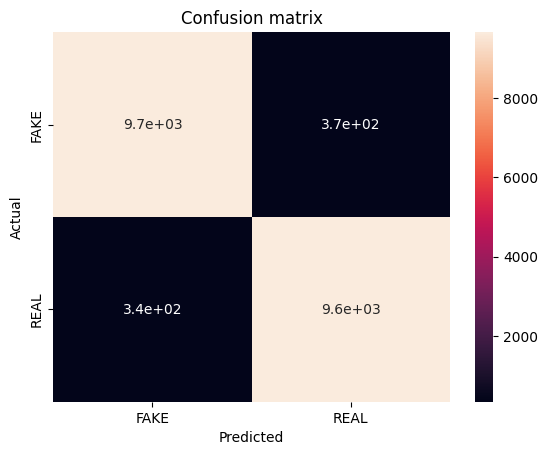

In [86]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion = confusion_matrix(labels, preds)
sns.heatmap(confusion, annot=True, xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])

plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

## Step 4: Visualise the classification

In [46]:
# Reload the learner before cutting so this cell can be re-run without issue
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.load('resnet18-cifake-6epoch')

# Cut the model right before the classification layer
new_head = cut_model(learn.model[-1], 2)
learn.model[-1] = new_head
learn.model.cuda()

# Run data through the new network to derive the feature vectors
x, y = dls.one_batch()
feature_vectors = learn.model(x)

c:\Users\deren\Git\elec4630\a3\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\deren\Git\elec4630\a3\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


fastai.data.core.DataLoaders

In [32]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(feature_vectors.cpu().detach().numpy())

Text(0.5, 1.0, 't-SNE model visualisation')

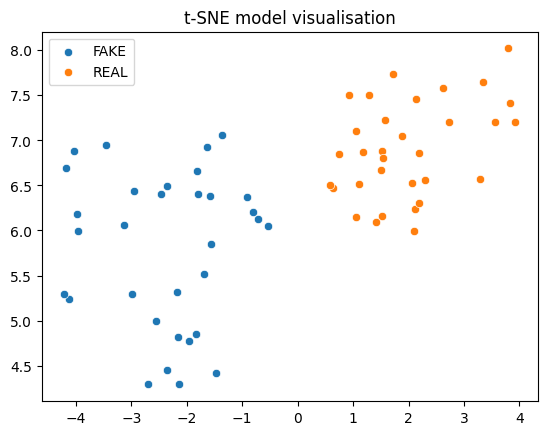

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = y.cpu().numpy()

_, ax = plt.subplots()

sns.scatterplot(x=tsne[:, 0][labels == 0], y=tsne[:, 1][labels == 0], label='FAKE', ax=ax)
sns.scatterplot(x=tsne[:, 0][labels == 1], y=tsne[:, 1][labels == 1], label='REAL', ax=ax)

ax.set_title('t-SNE model visualisation')

## References

[1] Bird, J.J., Lotfi, A. (2023). CIFAKE: Image Classification and Explainable Identification of AI-Generated Synthetic Images. arXiv preprint arXiv:2303.14126.

[2] Krizhevsky, A., & Hinton, G. (2009). Learning multiple layers of features from tiny images.